# EECE Homework 3

### Imports

In [76]:
# Widget to manipulate plots in Jupyter notebooks
#matplotlib widget 

import os
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=4
from sys import float_info  # Threshold smallest positive floating value

from math import ceil, floor 

import imageio
import matplotlib.animation as ani
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.pyplot as plt # For general plotting
from matplotlib.colors import LogNorm
from matplotlib.patches import Ellipse
from PIL import Image

import numpy as np

from scipy.optimize import linear_sum_assignment
from scipy.optimize import minimize
from scipy.stats import multivariate_normal as mvn

from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix, pairwise_distances_argmin

from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans

np.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
np.random.seed(7)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize
plt.rc('figure', titlesize=20)   # fontsize of the figure title

### Data-Generating Functions

In [62]:
def HW3generateDataQ1(N, pdf_params):
    # Use mean vectors to determine dimensionality of data
    d = pdf_params['mu'].shape[1]

    # Decide randomly which samples come from one of the Gaussian Components
    u = np.random.rand(N)
    # Determine thresholds based on the mixture weights/priors for the GMM
    thresh = np.cumsum(np.append(pdf_params['weights'].dot(pdf_params['priors'][0]), pdf_params['priors'][1]))
    thresh = np.insert(thresh, 0, 0)

    # Since only 2 classes, we can use logical indexing to decide between Class 0 and Class 1
    labels = u >= pdf_params['priors'][0]
    X = np.zeros((N, d))
    numGaussians = len(pdf_params['mu'])
    for i in range(1, numGaussians+1):
        # Get randomly sampled indices for Gaussian component
        idx = np.argwhere((thresh[i-1] <= u) & (u <= thresh[i]))[:, 0]
        X[idx, :] =  mvn.rvs(pdf_params['mu'][i-1], pdf_params['Sigma'][i-1], len(idx))

    return X, labels

### Evaluation Functions

In [63]:
# Generate ROC curve samples
def estimateROC(scores, labels, N_labels):
    # Sorting necessary so the resulting FPR and TPR axes plot threshold probabilities in order as a line
    sortedScore = sorted(scores)

    # Use gamma values that will account for every possible classification split
    # The epsilon is just to account for the two extremes of the ROC curve (TPR=FPR=0 and TPR=FPR=1)
    gammas = ([sortedScore[0] - float_info.epsilon] +
              sortedScore +
              [sortedScore[-1] + float_info.epsilon])

    # Calculate the decision label for each observation for each gamma
    decisions = [scores >= g for g in gammas]
    
    # Retrieve indices where FPs occur
    idxFP = [np.argwhere((d == 1) & (labels == 0)) for d in decisions]
    # Compute FP rates (FPR) as a fraction of total samples in the negative class
    FPR = [len(inds) / N_labels[0] for inds in idxFP]
    # Retrieve indices where TPs occur
    idxTP = [np.argwhere((d == 1) & (labels == 1)) for d in decisions]
    # Compute TP rates (TPR) as a fraction of total samples in the positive class
    TPR = [len(inds) / N_labels[1] for inds in idxTP]
    
    # ROC has FPR on the x-axis and TPR on the y-axis, but return others as well for convenience
    roc = {}
    roc['FPR'] = np.array(FPR)
    roc['TPR'] = np.array(TPR)

    return roc, gammas

def estimateClassMetrics(predictions, labels, N_labels):
    # Get indices and probability estimates of the four decision scenarios:
    # (true negative, false positive, false negative, true positive)
    classMetrics = {}
    
    # True Negative Probability Rate
    classMetrics['TN'] = np.argwhere((predictions == 0) & (labels == 0))
    classMetrics['TNR'] = len(classMetrics['TN']) / N_labels[0]
    # False Positive Probability Rate
    classMetrics['FP'] = np.argwhere((predictions == 1) & (labels == 0))
    classMetrics['FPR'] = len(classMetrics['FP']) / N_labels[0]
    # False Negative Probability Rate
    classMetrics['FN'] = np.argwhere((predictions == 0) & (labels == 1))
    classMetrics['FNR'] = len(classMetrics['FN']) / N_labels[1]
    # True Positive Probability Rate
    classMetrics['TP'] = np.argwhere((predictions == 1) & (labels == 1))
    classMetrics['TPR'] = len(classMetrics['TP']) / N_labels[1]

    return classMetrics

def estimateERMscores(X, pdf):
    # Compute class conditional likelihoods to express ratio test, where ratio is discriminant score
    # Recall that there is a mixture weighting for class 0!
    pxL0 = (pdf['weights'][0]*mvn.pdf(X, pdf['mu'][0], pdf['Sigma'][0])
                   + pdf['weights'][1]*mvn.pdf(X, pdf['mu'][1], pdf['Sigma'][1]))
    pxL1 = mvn.pdf(X, pdf['mu'][2], pdf['Sigma'][2])
    # Class conditional log likelihoods equate to decision boundary log gamma in the 0-1 loss case
    ermScores = np.log(pxL1) - np.log(pxL0)
    
    return ermScores

def createPredictionScoreGrid(bounds_X, bounds_Y, params, prediction_function, phi=None, num_coords=200):    
    # Note that I am creating a 200x200 rectangular grid
    xx, yy = np.meshgrid(np.linspace(bounds_X[0], bounds_X[1], num_coords), 
                         np.linspace(bounds_Y[0], bounds_Y[1], num_coords))

    # Flattening grid and feed into a fitted transformation function if provided
    grid = np.c_[xx.ravel(), yy.ravel()]
    if phi:
        grid = phi.transform(grid)

    # Z matrix are the predictions given the provided model parameters
    Z = prediction_function(grid, params).reshape(xx.shape)
    
    return xx, yy, Z

## EM Algorithm Functions

## Question 1

The number of true class labels for each dataset are :
[array([65, 35]), array([609, 391]), array([5915, 4085])]
The number of true class labels for validation dataset are : 
[11938  8062]


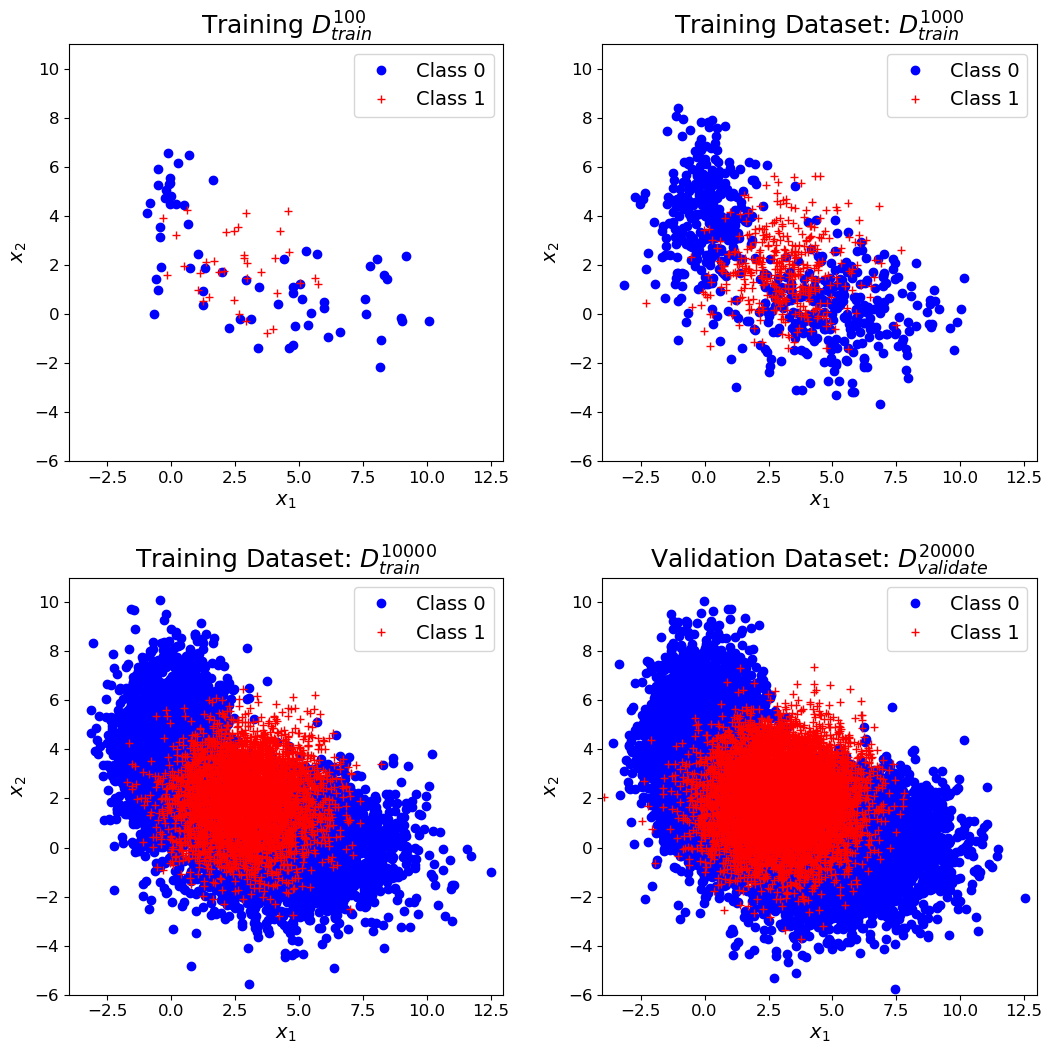

In [79]:
# Define dictionary for holding parameters of Gaussian Mixture Model
pdf = {}
# Priors for Class 0 = 0.6 and Class 1 = 0.4
pdf['priors'] = np.array([0.6, 0.4])
# Weights for the multicomponent gaussian of class 0
pdf['weights'] = np.array([0.5, 0.5])  
# Means for GMM
pdf['mu'] = np.array([[5, 0],
                      [0, 4],
                      [3, 2]])  
# Covariance matrices for GMM
pdf['Sigma'] = np.array([[[4, 0],
                          [0, 2]],
                         [[1, 0],
                          [0, 3]],
                         [[2, 0],
                          [0, 2]]]) 
    
# Number of training samples for each dataset
D_train = [100, 1000, 10000]
numDatasets = len(D_train)
# Making lists for the samples and labels
X_train = []
labels_train = []
N_labels_train = []
# Generate each training dataset using data generation function
D100, D100_labels  = HW3generateDataQ1(D_train[0], pdf)
D1K,  D1K_labels   = HW3generateDataQ1(D_train[1], pdf)
D10K, D10K_labels  = HW3generateDataQ1(D_train[2], pdf)
# Generate sample validation dataset using data generation function
D_validate = 20000
D20K, D20K_labels = HW3generateDataQ1(D_validate, pdf)
# Count up the number of samples per class in each dataset
# D100 samples
X_train.append(D100)
labels_train.append(D100_labels)
N_labels_train.append(np.array((sum(D100_labels == 0), sum(D100_labels == 1))))
# D1K samples
X_train.append(D1K)
labels_train.append(D1K_labels)
N_labels_train.append(np.array((sum(D1K_labels == 0), sum(D1K_labels == 1))))
# D10K samples
X_train.append(D10K)
labels_train.append(D10K_labels)
N_labels_train.append(np.array((sum(D10K_labels == 0), sum(D10K_labels == 1))))
# Print out and display the # of true class labels in each training dataset
print('The number of true class labels for each dataset are :')
print(N_labels_train)  
# D20K samples
Nl_valid = np.array((sum(D20K_labels == 0), sum(D20K_labels == 1)))
# Print out and display the # of true class labels in validation dataset
print('The number of true class labels for validation dataset are : ')
print(Nl_valid)
# Plot the original data and their true labels
fig, ax = plt.subplots(2, 2, figsize=(11, 11))
# Plot D100 train with correct class labels
ax[0, 0].plot(D100[D100_labels==0, 0], D100[D100_labels==0, 1], 'bo', label="Class 0")
ax[0, 0].plot(D100[D100_labels==1, 0], D100[D100_labels==1, 1], 'r+', label="Class 1")
ax[0, 0].set_title(r"Training $D^{%d}_{train}$" % (D_train[0]))
ax[0, 0].set_xlabel(r"$x_1$")
ax[0, 0].set_ylabel(r"$x_2$")
ax[0, 0].legend()
# Plot D10K train with correct class labels
ax[0, 1].plot(D1K[D1K_labels==0, 0], D1K[D1K_labels==0, 1], 'bo', label="Class 0")
ax[0, 1].plot(D1K[D1K_labels==1, 0], D1K[D1K_labels==1, 1], 'r+', label="Class 1")
ax[0, 1].set_title(r"Training Dataset: $D^{%d}_{train}$" % (D_train[1]))
ax[0, 1].set_xlabel(r"$x_1$")
ax[0, 1].set_ylabel(r"$x_2$")
ax[0, 1].legend()
# Plot D10K train with correct class labels
ax[1, 0].plot(D10K[D10K_labels==0, 0], D10K[D10K_labels==0, 1], 'bo', label="Class 0")
ax[1, 0].plot(D10K[D10K_labels==1, 0], D10K[D10K_labels==1, 1], 'r+', label="Class 1")
ax[1, 0].set_title(r"Training Dataset: $D^{%d}_{train}$" % (D_train[2]))
ax[1, 0].set_xlabel(r"$x_1$")
ax[1, 0].set_ylabel(r"$x_2$")
ax[1, 0].legend()
# Plot D20K validate with correct class labels
ax[1, 1].plot(D20K[D20K_labels==0, 0], D20K[D20K_labels==0, 1], 'bo', label="Class 0")
ax[1, 1].plot(D20K[D20K_labels==1, 0], D20K[D20K_labels==1, 1], 'r+', label="Class 1")
ax[1, 1].set_title(r"Validation Dataset: $D^{%d}_{validate}$" % (D_validate))
ax[1, 1].set_xlabel(r"$x_1$")
ax[1, 1].set_ylabel(r"$x_2$")
ax[1, 1].legend()
# Using validation set samples to limit axes (most samples drawn, highest odds of spanning sample space)
x1_valid_lim = (floor(np.min(D20K[:,0])), ceil(np.max(D20K[:,0])))
x2_valid_lim = (floor(np.min(D20K[:,1])), ceil(np.max(D20K[:,1])))
# Keep axis-equal so there is new skewed perspective due to a greater range along one axis
plt.setp(ax, xlim=x1_valid_lim, ylim=x2_valid_lim)
plt.tight_layout()
plt.show()


### Part 1:

The theoretically optimal classifier that will achieve min-P(error) using the knowledge of true pdf is the ERM classifier with 0-1 loss or Maximum a Posterior (MAP) classifier

\begin{equation*}

\frac{p(\mathbf{x}|L=1)}{p(\mathbf{x}|L=0)} > \frac{(\lambda_{10} - \lambda_{00})}{(\lambda_{01} - \lambda_{11})} \frac{P(L=0)}{P(L=1)} 

\end{equation*}

Since we are assuming 0-1 loss, this decision rule reduces to a MAP classification rule involving the likelihood ratio test of the class-conditional PDFs and the Priors of the model:

\begin{equation*}

\frac{p(\mathbf{x}|L=1)}{p(\mathbf{x}|L=0)} > \frac{P(L=0)}{P(L=1)} 

\end{equation*}

From here, we can insert the values of the Priors, and express the decision rule in terms of logarithms: 

$$
\ln \frac{p(\mathbf{x}|L=1)}{p(\mathbf{x}|L=0)} > \ln \frac{P(L=0)}{P(L=1)}  
$$
$$
\ln p(\mathbf{x}|L=1) - \ln p(\mathbf{x}|L=0) > \ln \left(\frac{0.6}{0.4}\right)  
$$
$$
\ln p(\mathbf{x}|L=1) - \ln p(\mathbf{x}|L=0) > \ln (1.5)  
$$

Thus, the MAP decision rules are :

$\ln p(\mathbf{x}|L=1) - \ln p(\mathbf{x}|L=0) > \ln (1.5) \rightarrow$ Decide Class 1 $(D=1)$   
$\ln p(\mathbf{x}|L=1) - \ln p(\mathbf{x}|L=0) < \ln (1.5) \rightarrow$ Decide Class 0 $(D=0)$   

From here, we will express the decision-threshold value as $\gamma = 1.5$

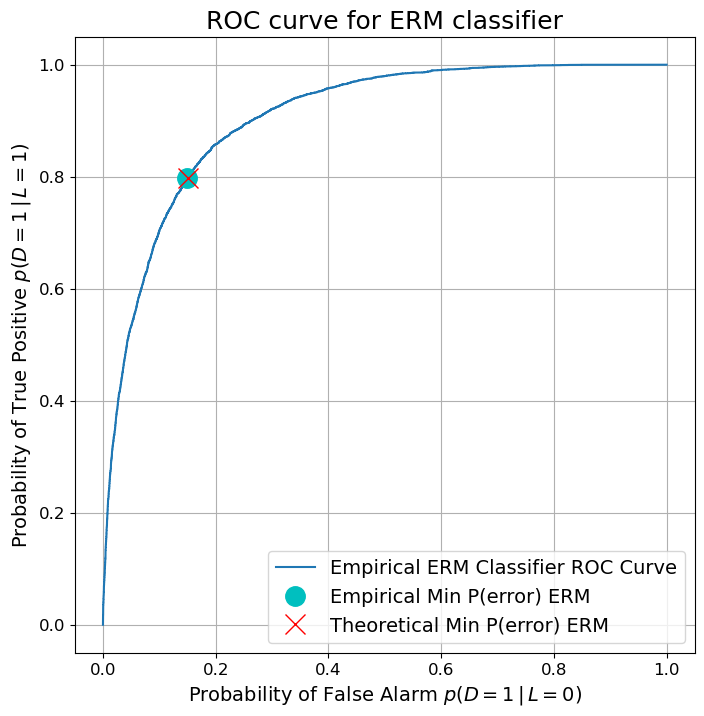

Min Empirical Pr(error) for ERM = 0.1708
Min Empirical Gamma = 1.510
Min Theoretical Pr(error) for ERM = 0.1709
Min Theoretical Gamma = 1.500


In [80]:
# Generate the class-conditional likelihoods and compute ERM scores
ermScores = estimateERMscores(D20K, pdf)
# Estimate the ROC curve
roc, gammas = estimateROC(ermScores,D20K_labels,Nl_valid)
# Plot the ROC curve with the empirical value for min-P(error)
fig_roc, ax_roc = plt.subplots(figsize=(8, 8));
ax_roc.plot(roc['FPR'], roc['TPR'], label="Empirical ERM Classifier ROC Curve")
ax_roc.set_xlabel(r"Probability of False Alarm $p(D=1\,|\,L=0)$")
ax_roc.set_ylabel(r"Probability of True Positive $p(D=1\,|\,L=1)$")
ax_roc.set_title('ROC curve for ERM classifier')
# ROC returns FPR vs TPR, but needs False Negative Rates, which is 1 - TPR
# Pr(error; γ) = p(D = 1|L = 0; γ)p(L = 0) + p(D = 0|L = 1; γ)p(L = 1)
#Perror_empirical = np.array((roc['FPR'], 1 - roc['TPR'])).T.dot(Nl_valid / D_validate)
N_class0 = Nl_valid[0]/D_validate
N_class1 = Nl_valid[1]/D_validate
Perror_empirical = roc['FPR']*N_class0 + (1-roc['TPR'])*N_class1
# Min prob error for the empirical gamma values
min_Perror_empirical = np.min(Perror_empirical)
min_idx_empirical = np.argmin(Perror_empirical)
# Compute theoretical gamma 
gamma_theoretical = pdf['priors'][0] / pdf['priors'][1]
MAP_decisions = ermScores >= np.log(gamma_theoretical)
# Calculate the estimates for TPR, FNR, FPR, and TNR
MAP_metrics = estimateClassMetrics(MAP_decisions, D20K_labels, Nl_valid)
# Compute probability of error using FPR and FNR and class priors
min_prob_error_map = np.array((MAP_metrics['FPR'] * pdf['priors'][0] + MAP_metrics['FNR'] * pdf['priors'][1]))
# Plot theoretical and empirical
ax_roc.plot(roc['FPR'][min_idx_empirical], roc['TPR'][min_idx_empirical], 'co', label="Empirical Min P(error) ERM",
            markersize=14)
ax_roc.plot(MAP_metrics['FPR'], MAP_metrics['TPR'], 'rx', label="Theoretical Min P(error) ERM", markersize=14)
ax_roc.set_xlabel(r"Probability of False Alarm $p(D=1\,|\,L=0)$")
ax_roc.set_ylabel(r"Probability of True Positive $p(D=1\,|\,L=1)$")
ax_roc.set_title('ROC curve for ERM classifier')

plt.grid(True)
plt.legend()
plt.show()

print("Min Empirical Pr(error) for ERM = {:.4f}".format(min_Perror_empirical))
print("Min Empirical Gamma = {:.3f}".format(np.exp(gammas[min_idx_empirical])))

print("Min Theoretical Pr(error) for ERM = {:.4f}".format(min_prob_error_map))
print("Min Theoretical Gamma = {:.3f}".format(gamma_theoretical))

Thus, from the estimations above  
min empirical $P(error) = 0.1748$ for the ERM classifier with empirical value of $\gamma = 1.329$  
min theoretical $P(error) = 0.1753$ for the ERM classifier with theoretical value of $\gamma = 1.5$

TypeError: 'numpy.ndarray' object is not callable

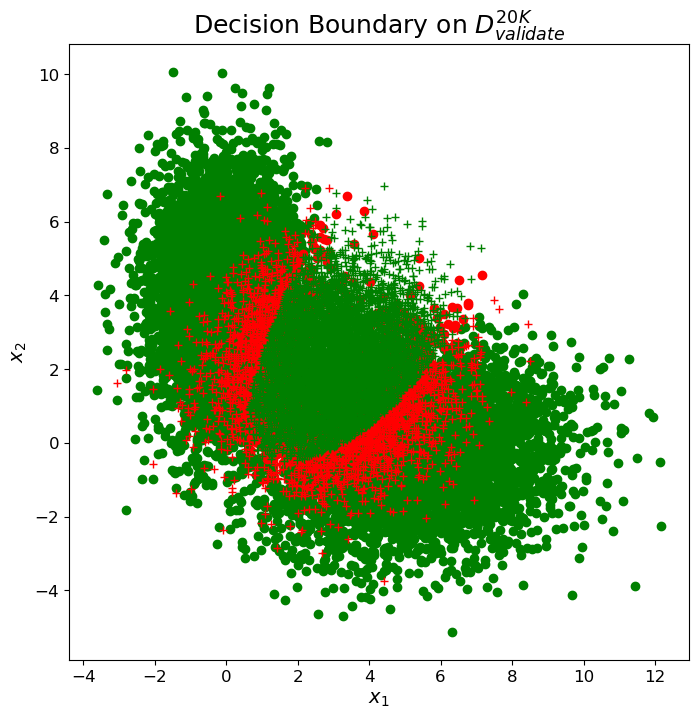

In [56]:
def plot_erm_decision_boundaries(ax, X, params, prediction_function, phi=None):
    bounds_X = (floor(np.min(X[:,0])), ceil(np.max(X[:,0])))
    bounds_Y = (floor(np.min(X[:,1])), ceil(np.max(X[:,1])))
    
    # Get grid coordinates and corresponding discriminant scores for the prediction function
    xx, yy, Z = create_prediction_score_grid(bounds_X, bounds_Y, params, prediction_function, phi)

    # The next four lines just determine how I'll draw contour lines at 9 discriminant score grid value levels
    equal_levels = np.array((0.3, 0.6, 0.9))
    min_Z = np.min(Z) * equal_levels[::-1] # Reversing the levels list [.9, .6, .3]
    max_Z = np.max(Z) * equal_levels
    contour_levels = min_Z.tolist() + [0] + max_Z.tolist()

    # Contour plot of decision boundaries
    cs = ax.contour(xx, yy, Z, contour_levels, colors='k')
    ax.clabel(cs, fontsize=16, inline=1)
    
# Defining new figure to plot the validation set samples with overlaid decision boundaries
fig_disc_grid, ax_disc = plt.subplots(figsize=(8, 8));

ax_disc.set_title(r"Decision Boundary on $D^{20K}_{validate}$")
# class 0 circle, class 1 +, correct green, incorrect red
ax_disc.plot(D20K[MAP_metrics['TN'], 0], D20K[MAP_metrics['TN'], 1], 'og', label="Correct Class 0");
ax_disc.plot(D20K[MAP_metrics['FP'], 0], D20K[MAP_metrics['FP'], 1], 'or', label="Incorrect Class 0");
ax_disc.plot(D20K[MAP_metrics['FN'], 0], D20K[MAP_metrics['FN'], 1], '+r', label="Incorrect Class 1");
ax_disc.plot(D20K[MAP_metrics['TP'], 0], D20K[MAP_metrics['TP'], 1], '+g', label="Correct Class 1");
ax_disc.set_xlabel(r"$x_1$")
ax_disc.set_ylabel(r"$x_2$")

plot_erm_decision_boundaries(ax_disc, D20K, pdf, ermScores)

# Keep axis-equal so there is new skewed perspective due to a greater range along one axis
ax_disc.set_aspect('equal')
ax_disc.legend()
plt.tight_layout()
plt.show()


### Part 2a:

In [69]:
def estimateMLE(X, labels, N_labels):
    # Use logical Indexing to extract Class 0 and Class 1 Samples
    idx0 = labels < 1
    idx1 = labels > 0
    # Use indices above to separate Dataset into Class 0 and Class 1 samples
    C0 = X[idx0]
    C1 = X[idx1]
    # Create dictionaries for each class to store MLE parameters for each
    X0 = {}
    X1 = {}
    # For Class 1, find Sample Mean, Sample Covarience and # samples to calculate Class Prior for MLE parameters
    X1['mu'] = np.mean(C1,axis=0)
    X1['Sigma'] = np.cov(C1.T)
    X1['prior'] = len(C1)/N_labels
    # Use EM Algorithm and GaussianMixture object to estimate the MLE parameters for Class 0
    gmm = GaussianMixture(n_components = 2,n_init = 10, init_params='random_from_data').fit(C0)
    X0['mu'] = gmm.means_
    X0['Sigma'] = gmm.covariances_
    X0['weights'] = gmm.weights_
    X0['prior'] = np.sum(gmm.weights_*(len(C0)/N_labels))
    # Print MLE parameters to console
    print("MLE parameters for Class 0 are: ")
    print("Component #1: \nw1 =",X0['weights'][0],"\n\u03BC01 =",X0['mu'][0], "\n\u03A301 =",X0['Sigma'][0])
    print("Component #2: \nw2 =",X0['weights'][1],"\n\u03BC02 =",X0['mu'][1], "\n\u03A302 =",X0['Sigma'][1])
    print("Prior Value for Class 0: P(L=0) =", round(X0['prior'],4))
    print("MLE parameters for Class 1 are: ")
    print("\u03BC1 =",X1["mu"], "\n\u03A31 =",X1['Sigma'],"\nPrior value for Class 1: P(L=1) =",round(X1['prior'],4))
    
    return X0, X1

def estimateERMscoresV2(X, A, B):
    # Compute class conditional likelihoods to express ratio test, where ratio is discriminant score
    # Recall that there is a mixture weighting for class 0!
    pxL0 = (A['weights'][0]*mvn.pdf(X, A['mu'][0], A['Sigma'][0])
                   + A['weights'][1]*mvn.pdf(X, A['mu'][1], A['Sigma'][1]))
    pxL1 = mvn.pdf(X, B['mu'], B['Sigma'])
    # Class conditional log likelihoods equate to decision boundary log gamma in the 0-1 loss case
    ermScores = np.log(pxL1) - np.log(pxL0)
    
    return ermScores

In [81]:
# Use estimateMLE function to calculate the MLE parameters for D10K dataset using just the samples
Class0_10K, Class1_10K = estimateMLE(D10K, D10K_labels, D_train[2])

MLE parameters for Class 0 are: 
Component #1: 
w1 = 0.4749241737656275 
μ01 = [4.90459804 0.00437509] 
Σ01 = [[4.10767903 0.035769  ]
 [0.035769   2.02239383]]
Component #2: 
w2 = 0.5250758262343724 
μ02 = [-0.00094393  4.01328161] 
Σ02 = [[1.01308525 0.05529933]
 [0.05529933 3.06647151]]
Prior Value for Class 0: P(L=0) = 0.5915
MLE parameters for Class 1 are: 
μ1 = [2.96621234 1.98195459] 
Σ1 = [[2.02802519 0.02463674]
 [0.02463674 2.00481197]] 
Prior value for Class 1: P(L=1) = 0.4085


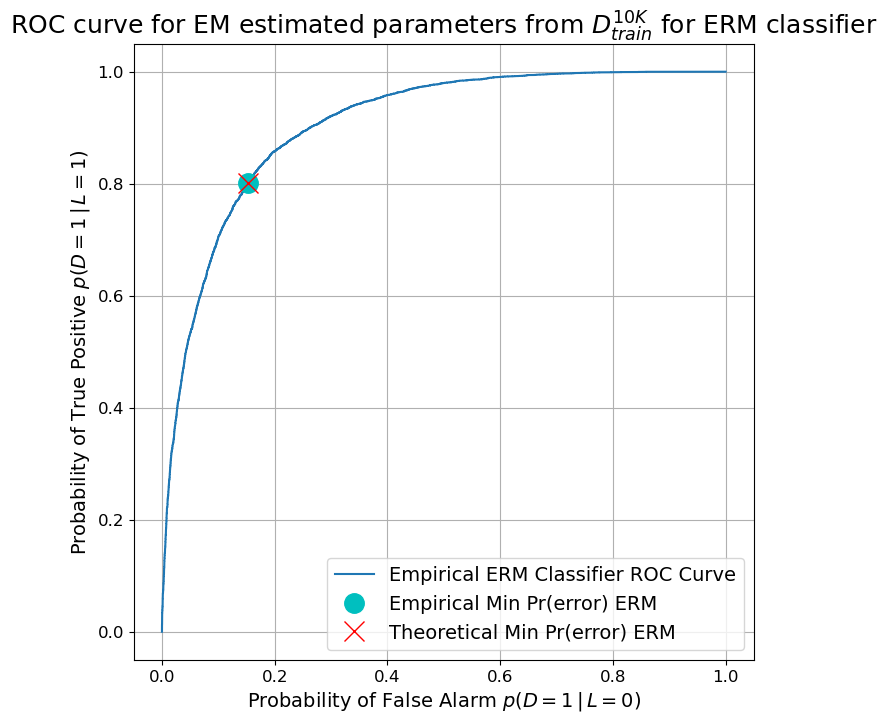

Min Empirical P(error) for ERM = 0.1708
Min Empirical Gamma = 1.500
Min Theoretical P(error) for ERM = 0.1711
Min Theoretical Gamma = 1.500


In [83]:
# Generate the class-conditional likelihoods and compute ERM scores
ermScores_10K = estimateERMscoresV2(D20K, Class0_10K, Class1_10K)
# Estimate the ROC curve
roc_10K, gammas_10K = estimateROC(ermScores_10K,D20K_labels,Nl_valid)
# Plot the ROC curve with the empirical value for min-P(error)
fig_roc_10K, ax_roc_10K = plt.subplots(figsize=(8, 8));
ax_roc_10K.plot(roc_10K['FPR'], roc_10K['TPR'], label="Empirical ERM Classifier ROC Curve")
ax_roc_10K.set_xlabel(r"Probability of False Alarm $p(D=1\,|\,L=0)$")
ax_roc_10K.set_ylabel(r"Probability of True Positive $p(D=1\,|\,L=1)$")
# ROC returns FPR vs TPR, but needs False Negative Rates, which is 1 - TPR
# Pr(error; γ) = p(D = 1|L = 0; γ)p(L = 0) + p(D = 0|L = 1; γ)p(L = 1)
Perror_empirical_10K = np.array((roc_10K['FPR'], 1 - roc_10K['TPR'])).T.dot(Nl_valid / D_validate)
# Min prob error for the empirical gamma values
min_Perror_empirical_10K = np.min(Perror_empirical_10K)
min_idx_empirical_10K = np.argmin(Perror_empirical_10K)
# Compute theoretical gamma 
gamma_theoretical_10K = Class0_10K['prior'] / Class1_10K['prior']
MAP_decisions_10K = ermScores_10K > np.log(gamma_theoretical)
# Calculate the estimates for TPR, FNR, FPR, and TNR
MAP_metrics_10K = estimateClassMetrics(MAP_decisions_10K, D20K_labels, Nl_valid)
# Compute probability of error using FPR and FNR and class priors
min_prob_error_map_10K = np.array((MAP_metrics_10K['FPR'] * Class0_10K['prior'] + MAP_metrics_10K['FNR'] * Class1_10K['prior']))
# Plot theoretical and empirical
ax_roc_10K.plot(roc_10K['FPR'][min_idx_empirical_10K], roc_10K['TPR'][min_idx_empirical_10K], 'co', label="Empirical Min Pr(error) ERM",
            markersize=14)
ax_roc_10K.plot(MAP_metrics_10K['FPR'], MAP_metrics_10K['TPR'], 'rx', label="Theoretical Min Pr(error) ERM", markersize=14)
ax_roc_10K.set_xlabel(r"Probability of False Alarm $p(D=1\,|\,L=0)$")
ax_roc_10K.set_ylabel(r"Probability of True Positive $p(D=1\,|\,L=1)$")
ax_roc_10K.set_title('ROC curve for EM estimated parameters from $D^{10K}_{train}$ for ERM classifier')

plt.grid(True)
plt.legend()
plt.show()

print("Min Empirical P(error) for ERM = {:.4f}".format(min_Perror_empirical_10K))
print("Min Empirical Gamma = {:.3f}".format(np.exp(gammas_10K[min_idx_empirical_10K])))

print("Min Theoretical P(error) for ERM = {:.4f}".format(min_prob_error_map_10K))
print("Min Theoretical Gamma = {:.3f}".format(gamma_theoretical))

### Part 2b:

In [84]:
# Use estimateMLE function to calculate the MLE parameters for D1000 dataset using just the samples
Class0_1K, Class1_1K = estimateMLE(D1K, D1K_labels, D_train[1])

MLE parameters for Class 0 are: 
Component #1: 
w1 = 0.4848200279886821 
μ01 = [5.05881979 0.11322488] 
Σ01 = [[ 3.85366525 -0.02812353]
 [-0.02812353  1.96427345]]
Component #2: 
w2 = 0.5151799720113177 
μ02 = [0.03864031 4.00524791] 
Σ02 = [[0.95376155 0.09399782]
 [0.09399782 2.81218181]]
Prior Value for Class 0: P(L=0) = 0.609
MLE parameters for Class 1 are: 
μ1 = [3.05935063 1.84404866] 
Σ1 = [[2.22422843 0.02738178]
 [0.02738178 2.02587521]] 
Prior value for Class 1: P(L=1) = 0.391


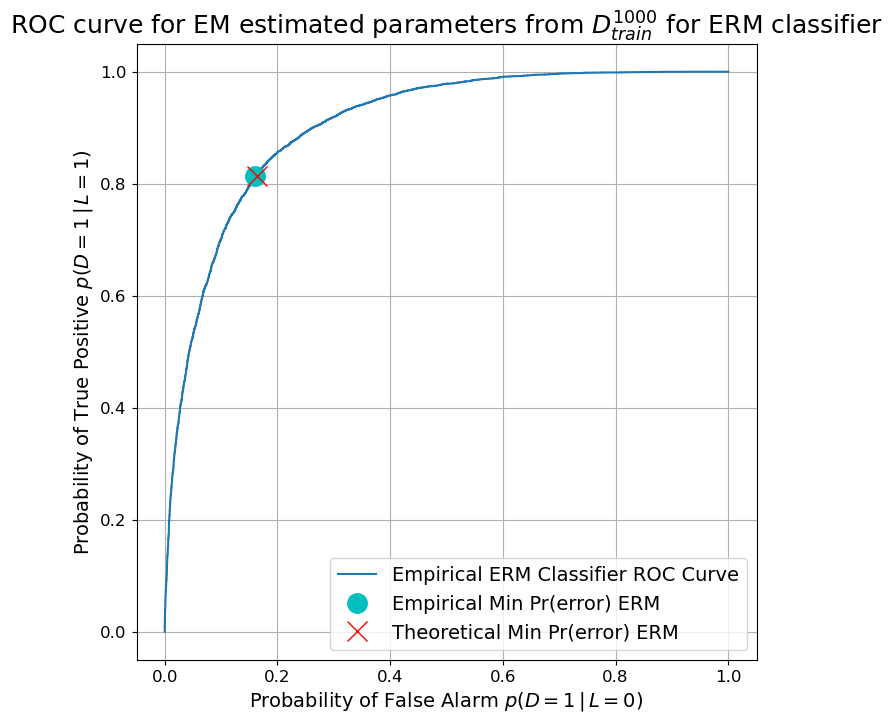

Min Empirical P(error) for ERM = 0.1713
Min Empirical Gamma = 1.520
Min Theoretical P(error) for ERM = 0.1719
Min Theoretical Gamma = 1.500


In [85]:
# Generate the class-conditional likelihoods and compute ERM scores
ermScores_1K = estimateERMscoresV2(D20K, Class0_1K, Class1_1K)
# Estimate the ROC curve
roc_1K, gammas_1K = estimateROC(ermScores_1K,D20K_labels,Nl_valid)
# Plot the ROC curve with the empirical value for min-P(error)
fig_roc_1K, ax_roc_1K = plt.subplots(figsize=(8, 8));
ax_roc_1K.plot(roc_1K['FPR'], roc_1K['TPR'], label="Empirical ERM Classifier ROC Curve")
ax_roc_1K.set_xlabel(r"Probability of False Alarm $p(D=1\,|\,L=0)$")
ax_roc_1K.set_ylabel(r"Probability of True Positive $p(D=1\,|\,L=1)$")
# ROC returns FPR vs TPR, but needs False Negative Rates, which is 1 - TPR
# Pr(error; γ) = p(D = 1|L = 0; γ)p(L = 0) + p(D = 0|L = 1; γ)p(L = 1)
Perror_empirical_1K = np.array((roc_1K['FPR'], 1 - roc_1K['TPR'])).T.dot(Nl_valid / D_validate)
# Min prob error for the empirical gamma values
min_Perror_empirical_1K = np.min(Perror_empirical_1K)
min_idx_empirical_1K = np.argmin(Perror_empirical_1K)
# Compute theoretical gamma 
gamma_theoretical_1K = Class0_1K['prior'] / Class1_1K['prior']
MAP_decisions_1K = ermScores_1K > np.log(gamma_theoretical)
# Calculate the estimates for TPR, FNR, FPR, and TNR
MAP_metrics_1K = estimateClassMetrics(MAP_decisions_1K, D20K_labels, Nl_valid)
# Compute probability of error using FPR and FNR and class priors
min_prob_error_map_1K = np.array((MAP_metrics_1K['FPR'] * Class0_1K['prior'] + MAP_metrics_1K['FNR'] * Class1_1K['prior']))
# Plot theoretical and empirical
ax_roc_1K.plot(roc_1K['FPR'][min_idx_empirical_1K], roc_1K['TPR'][min_idx_empirical_1K], 'co', label="Empirical Min Pr(error) ERM",
            markersize=14)
ax_roc_1K.plot(MAP_metrics_1K['FPR'], MAP_metrics_1K['TPR'], 'rx', label="Theoretical Min Pr(error) ERM", markersize=14)
ax_roc_1K.set_xlabel(r"Probability of False Alarm $p(D=1\,|\,L=0)$")
ax_roc_1K.set_ylabel(r"Probability of True Positive $p(D=1\,|\,L=1)$")
ax_roc_1K.set_title('ROC curve for EM estimated parameters from $D^{1000}_{train}$ for ERM classifier')

plt.grid(True)
plt.legend()
plt.show()

print("Min Empirical P(error) for ERM = {:.4f}".format(min_Perror_empirical_1K))
print("Min Empirical Gamma = {:.3f}".format(np.exp(gammas_1K[min_idx_empirical_1K])))

print("Min Theoretical P(error) for ERM = {:.4f}".format(min_prob_error_map_1K))
print("Min Theoretical Gamma = {:.3f}".format(gamma_theoretical))

### Part 2c:

In [86]:
# Use estimateMLE function to calculate the MLE parameters for D10K dataset using just the samples
Class0_100, Class1_100 = estimateMLE(D100, D100_labels, D_train[0])

MLE parameters for Class 0 are: 
Component #1: 
w1 = 0.6930129860831892 
μ01 = [4.74803644 0.60413727] 
Σ01 = [[ 8.63146683 -0.73835373]
 [-0.73835373  1.49016587]]
Component #2: 
w2 = 0.3069870139168108 
μ02 = [-0.02493863  4.94525416] 
Σ02 = [[0.32599595 0.13970419]
 [0.13970419 0.89190335]]
Prior Value for Class 0: P(L=0) = 0.65
MLE parameters for Class 1 are: 
μ1 = [2.6248776 1.9161448] 
Σ1 = [[ 2.54231672 -0.39170124]
 [-0.39170124  1.82283037]] 
Prior value for Class 1: P(L=1) = 0.35


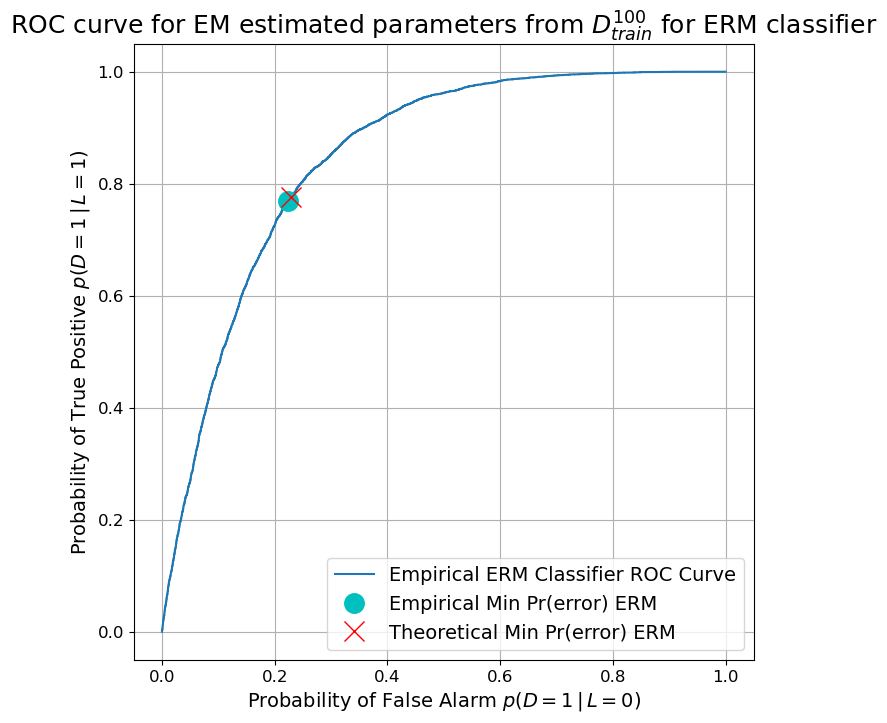

Min Empirical P(error) for ERM = 0.2260
Min Empirical Gamma = 1.538
Min Theoretical P(error) for ERM = 0.2273
Min Theoretical Gamma = 1.500


In [87]:
# Generate the class-conditional likelihoods and compute ERM scores
ermScores_100 = estimateERMscoresV2(D20K, Class0_100, Class1_100)
# Estimate the ROC curve
roc_100, gammas_100 = estimateROC(ermScores_100,D20K_labels,Nl_valid)
# Plot the ROC curve with the empirical value for min-P(error)
fig_roc_100, ax_roc_100 = plt.subplots(figsize=(8, 8));
ax_roc_100.plot(roc_100['FPR'], roc_100['TPR'], label="Empirical ERM Classifier ROC Curve")
ax_roc_100.set_xlabel(r"Probability of False Alarm $p(D=1\,|\,L=0)$")
ax_roc_100.set_ylabel(r"Probability of True Positive $p(D=1\,|\,L=1)$")
# ROC returns FPR vs TPR, but needs False Negative Rates, which is 1 - TPR
# Pr(error; γ) = p(D = 1|L = 0; γ)p(L = 0) + p(D = 0|L = 1; γ)p(L = 1)
Perror_empirical_100 = np.array((roc_100['FPR'], 1 - roc_100['TPR'])).T.dot(Nl_valid / D_validate)
# Min prob error for the empirical gamma values
min_Perror_empirical_100 = np.min(Perror_empirical_100)
min_idx_empirical_100 = np.argmin(Perror_empirical_100)
# Compute theoretical gamma 
gamma_theoretical_100 = Class0_100['prior'] / Class1_100['prior']
MAP_decisions_100 = ermScores_100 > np.log(gamma_theoretical)
# Calculate the estimates for TPR, FNR, FPR, and TNR
MAP_metrics_100 = estimateClassMetrics(MAP_decisions_100, D20K_labels, Nl_valid)
# Compute probability of error using FPR and FNR and class priors
min_prob_error_map_100 = np.array((MAP_metrics_100['FPR'] * Class0_100['prior'] + MAP_metrics_100['FNR'] * Class1_100['prior']))
# Plot theoretical and empirical
ax_roc_100.plot(roc_100['FPR'][min_idx_empirical_100], roc_100['TPR'][min_idx_empirical_100], 'co', label="Empirical Min Pr(error) ERM",
            markersize=14)
ax_roc_100.plot(MAP_metrics_100['FPR'], MAP_metrics_100['TPR'], 'rx', label="Theoretical Min Pr(error) ERM", markersize=14)
ax_roc_100.set_xlabel(r"Probability of False Alarm $p(D=1\,|\,L=0)$")
ax_roc_100.set_ylabel(r"Probability of True Positive $p(D=1\,|\,L=1)$")
ax_roc_100.set_title('ROC curve for EM estimated parameters from $D^{100}_{train}$ for ERM classifier')

plt.grid(True)
plt.legend()
plt.show()

print("Min Empirical P(error) for ERM = {:.4f}".format(min_Perror_empirical_100))
print("Min Empirical Gamma = {:.3f}".format(np.exp(gammas_100[min_idx_empirical_100])))

print("Min Theoretical P(error) for ERM = {:.4f}".format(min_prob_error_map_100))
print("Min Theoretical Gamma = {:.3f}".format(gamma_theoretical))

From the repeated estimations of the ROC curves using the training sets, we can observe that the performance of the min-$P(error)$ classifier is dependent on the number of training samples we used before attempting to classifiy the $D^{20K}_{validate}$ dataset. We observe that the performance of the min-$P(error)$ classifier and ROC curves becomes worse when using less and less training samples.  
 
When using the $D^{10K}_{train}$ dataset, the ROC curve looks almost identical to the ROC curve generated from the $D^{20K}_{validate}$ dataset and generated an empirical min-$P(error)$ = 0.1757, which was close in value to the min-$P(error)$ achieved with the $D^{10K}_{train}$ dataset = 0.1743  
  
When using the $D^{1000}_{train}$ dataset, the ROC curve has looks worse than the previous and generated an empirical min-$P(error)$ = 0.2894, which is about a 60% increase in the min error achieved using only 1000 training samples.  
  
Lastly, when using the $D^{100}_{train}$ dataset, the ROC curve is almost linearly increasing signifying a very poor performance for this iteration of the ERM classifier, which achieved an empirical min-$P(error)$ = 0.4040.  
  
This demonstrates that when we are data-starved for training samples for our ERM classifier we should expect a poorer performance than if we have an abundance of training samples. 

### Part 3a 
Using the maximum likelihood parameter estimation technique train a logistic-linear-function-based approximation  
of class label posterior function given a sample. As in part 2, repeat the training process for each of the three  
training sets to see the effect of training set sample count; use the validation set for performance assessment in  
each case. When optimizing the parameters, specify the optimization problem as minimization of the negative-log-likelihood  
of the training dataset, and use your favorite numerical optimization approach, such as gradient descent or Matlab’s   
_fminsearch_ or Python’s _minimize_.

Binary logistic regression model is specified as:  

\begin{align*}

p(l|\mathbf{x}; \boldsymbol{\theta}) & = \text{Ber}\left(l| g(\mathbf{w}^\intercal z(\mathbf{x}))\right) = g\left((\mathbf{w}^\intercal z(\mathbf{x})\right)^l \left(1-g(\mathbf{w}^\intercal z(\mathbf{x}))\right)^{(1-l)}, 

\end{align*}  
  
where $\phi(\mathbf{x})$ is a fixed transformation of the inputs and $l$ is the true label variable. The log-likelihood, $LL(\boldsymbol{\theta})$, for this binary classifier given a dataset with $N$ samples can then be written as: 



\begin{equation*}
LL(\theta) = \frac{1}{N} \sum_{i=1}^{N}\left[l^{(i)} \log g\Big(\textbf{w}^{T}\phi(\textbf{x}^{(i)})\Big) + (1-l^{(i)})\log\Big(1-g(\textbf{w}^{T}\phi(\textbf{x}^{(i)}))\Big)\right]
\end{equation*}  
Minimizing the Negative-Log-Likelihood to derive the MLE for the model's parameters, $\theta_{MLE} = \mathbf{w}^*$, can then be framed as:  
  
\begin{align*}

\mathbf{w}^* = \mathop{\rm argmin} \text{NLL}(\boldsymbol{\theta}) = - \frac{1}{N} \sum_{i=1}^N \left[ {l^{(i)}} \log g\left(\mathbf{w}^\intercal \phi(\mathbf{x}^{(i)})\right) + (1-l^{(i)}) \log \left(1-g(\mathbf{w}^\intercal \phi(\mathbf{x}^{(i)}))\right) \right] \end{align*}  
 


In [115]:
epsilon = 1e-7 # Epsilon; smallest positive floating value

# Define the logistic/sigmoid function
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

# Define the prediction function l = 1 / (1 + np.exp(-X*w))
# X.dot(w) inputs to the sigmoid referred to as logits
def logisticPrediction(X, w):
    z = X.dot(w)
    return sigmoid(z)

# Negative log Likelihood is equivalent to Binary Cross-Entropy Loss Function
def NLL(labels, predictions):
    # Limit values within arrays with addition of epsilon for avoidance of underflow
    predictions = np.clip(predictions, epsilon, 1 - epsilon)
    # log of class-conditional pdf for Class 0 - log p(L=0 | x; theta)
    log_p0 = (1 - labels) * np.log(1 - predictions + epsilon)
    # log of class-conditional pdf for Class 1 - log p(L=1 | x; theta)
    log_p1 = labels * np.log(predictions + epsilon)
    # Take negative result of mean-summation of log likelihoods
    return -np.mean(log_p0 + log_p1, axis=0)
def estimateLogisticMLE(X, labels):   
    # Dimensionality including the addition of bias term
    theta0 = np.random.randn(X.shape[1])
    # Calculate the MLE parameter w* for the model using minimize() function
    cost = lambda w: NLL(labels, logisticPrediction(X, w))
    resultMLE = minimize(cost, theta0, tol=1e-6)
    # Return the solution array 'x' from minimize() function which is our MLE parameter - w*
    return resultMLE.x

# Function to compute classification results and plot correct and incorrect predictions 
def estimateLogisticResults(ax, X, w, labels, N_labels, phi=None):
    #Report the probability of error and plot the classified data, plus predicted 
    #decision contours of the logistic classifier applied to the phi-transformed data.   
    predictions = logisticPrediction(phi.fit_transform(X), w)
    # Predicted decisions based on the default 0.5 threshold (higher probability mass on one side or the other)
    decisions = np.array(predictions >= 0.5)
    logistic_metrics = estimateClassMetrics(decisions, labels, N_labels)
    # To compute probability of error, we need FPR and FNR
    prob_error = np.array((logistic_metrics['FPR'], logistic_metrics['FNR'])).T.dot(N_labels / labels.shape[0])
    # Plot correct and incorrect decisions (green = correct, red = incorrect)
    ax.plot(X[logistic_metrics['TN'], 0], X[logistic_metrics['TN'], 1], 'og', label="Correct Class 0");
    ax.plot(X[logistic_metrics['FP'], 0], X[logistic_metrics['FP'], 1], 'or', label="Incorrect Class 0");
    ax.plot(X[logistic_metrics['FN'], 0], X[logistic_metrics['FN'], 1], '+r', label="Incorrect Class 1");
    ax.plot(X[logistic_metrics['TP'], 0], X[logistic_metrics['TP'], 1], '+g', label="Correct Class 1");
    # Get grid coordinates and corresponding probability scores for the prediction function
    # Draw the decision boundary based on the phi transformation of input features x
    # Re-use the bounds from the validation set's x1 and x2 axes (global variables)
    xx, yy, Z = createPredictionScoreGrid(x1_valid_lim, x2_valid_lim, w, logisticPrediction, phi)

    # Once reshaped as a grid, plot contour of probabilities per input feature (ignoring bias)
    cs = ax.contour(xx, yy, Z, levels=1, colors='k')
    
    ax.set_xlabel(r"$x_1$")
    ax.set_ylabel(r"$x_2$")
    
    return prob_error

After obtaining our MLE $\mathbf{w}^*$, we can then apply the logistic function to every transformed sample $\phi(\mathbf{x}^{(i)})$ in the $D^{20K}_{validation}$ dataset, and proceedingly make classification decisions based on the rule:  

$$ 
D(\mathbf{x}^{(i)}) = \begin{cases} 1 & \text{if} \; g\left(\mathbf{w}^{*\intercal} \phi(\mathbf{x}^{(i)})\right) \geq 0.5 \\ 0 & \text{otherwise} \end{cases}  
$$

This is derived from the fact that we choose Class 1 when:  

\begin{align*}

p(L=1 | \mathbf{x}; \boldsymbol{\theta}) > p(L=0 | \mathbf{x}; \boldsymbol{\theta})  
\end{align*}  
  
which is in the binary case when $ p(L=1 | \mathbf{x}; \boldsymbol{\theta}) \geq 0.5 $ or equivalently when $ g\left(\mathbf{w}^{*\intercal} \phi(\mathbf{x}^{(i)})\right) \geq 0.5 $, as the logistic function outputs posterior probability of class 1 being true.  
Hence, we can use the decision rule $D(\mathbf{x})$ described above


Logistic-Linear N=100; MLE for w: [-0.02470038 -0.13056203 -0.10890023]
Training set error for the N=100 classifier is 0.360
Validation set error for the N=100 classifier is 0.412




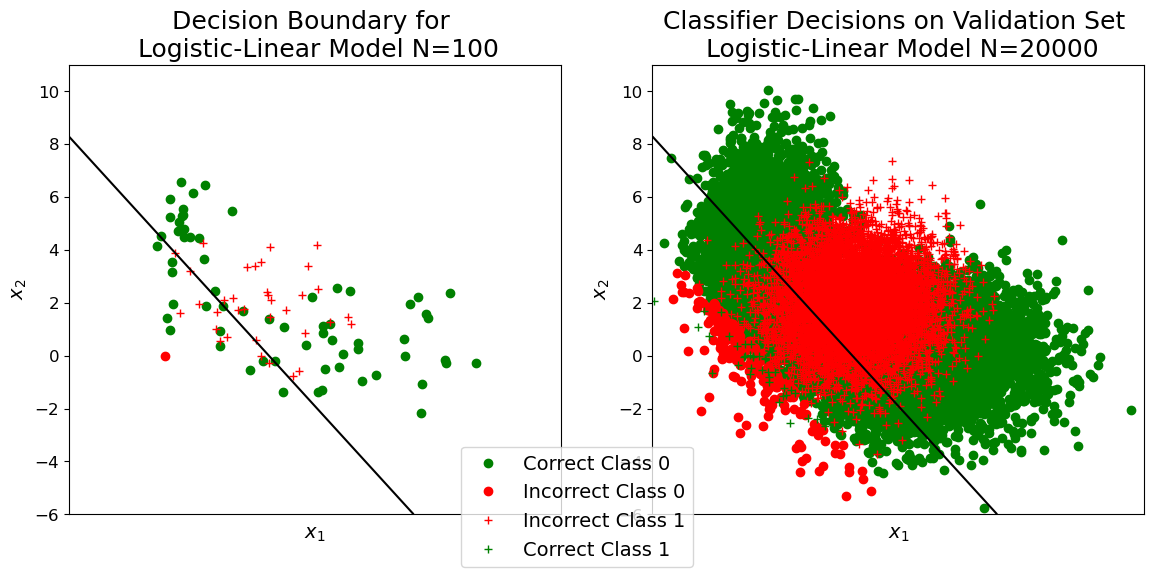

In [116]:
# Define phi transformation to only include a bias column
phi = PolynomialFeatures(degree=1)
# Figure for D100 training decision boundary and D20K Classifier Decisions
fig_linear, (ax1, ax2) = plt.subplots(1,2, figsize = (12,6));
# D100 training dataset
w_MLE = estimateLogisticMLE(phi.fit_transform(D100), D100_labels)
print("Logistic-Linear N={}; MLE for w: {}".format(100, w_MLE))
prob_error = estimateLogisticResults(ax1, D100, w_MLE, D100_labels, N_labels_train[0], phi)
print("Training set error for the N={} classifier is {:.3f}".format(100, prob_error))
ax1.set_title("Decision Boundary for \n Logistic-Linear Model N={}".format(100))
ax1.set_xticks([])
prob_error = estimateLogisticResults(ax2, D20K, w_MLE, D20K_labels, Nl_valid, phi)
ax2.set_title("Classifier Decisions on Validation Set \n Logistic-Linear Model N={}".format(D_validate))
print("Validation set error for the N={} classifier is {:.3f}\n\n".format(100, prob_error))
ax2.set_xticks([])
# Again use the most sampled subset (validation) to define x-y limits
plt.setp((ax1, ax2), xlim=x1_valid_lim, ylim=x2_valid_lim)
# Adjust subplot positions
plt.subplots_adjust(hspace=0.3)
# Super plot the legends
handles, labels = ax2.get_legend_handles_labels()
fig_linear.legend(handles, labels, loc='lower center')
plt.tight_layout()
plt.show()

Logistic-Linear N=1000; MLE for w: [-0.7110517   0.09561743  0.00190777]
Training set error for the N=1000 classifier is 0.423
Validation set error for the N=1000 classifier is 0.435




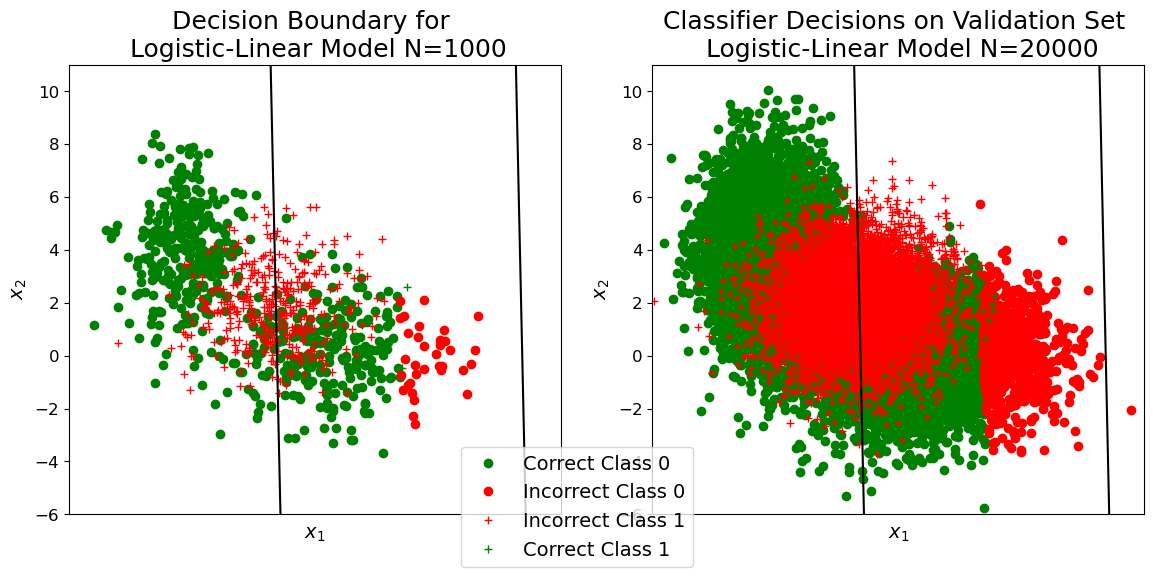

In [117]:
# Figure for D1000 training decision boundary and D20K Classifier Decisions
fig_linear, (ax1, ax2) = plt.subplots(1,2, figsize = (12,6));
# D1000 training dataset
w_mle = estimateLogisticMLE(phi.fit_transform(D1K), D1K_labels)
print("Logistic-Linear N={}; MLE for w: {}".format(1000, w_mle))
prob_error = estimateLogisticResults(ax1, D1K, w_mle, D1K_labels, N_labels_train[1], phi)
print("Training set error for the N={} classifier is {:.3f}".format(1000, prob_error))
ax1.set_title("Decision Boundary for \n Logistic-Linear Model N={}".format(1000))
ax1.set_xticks([])
prob_error = estimateLogisticResults(ax2, D20K, w_mle, D20K_labels, Nl_valid, phi)
ax2.set_title("Classifier Decisions on Validation Set \n Logistic-Linear Model N={}".format(D_validate))
print("Validation set error for the N={} classifier is {:.3f}\n\n".format(1000, prob_error))
ax2.set_xticks([])
# Again use the most sampled subset (validation) to define x-y limits
plt.setp((ax1, ax2), xlim=x1_valid_lim, ylim=x2_valid_lim)
# Adjust subplot positions
plt.subplots_adjust(hspace=0.3)
# Super plot the legends
handles, labels = ax2.get_legend_handles_labels()
fig_linear.legend(handles, labels, loc='lower center')
plt.tight_layout()
plt.show()

Logistic-Linear N=10000; MLE for w: [-0.84207413  0.13530399  0.05586729]
Training set error for the N=10000 classifier is 0.460
Validation set error for the N=10000 classifier is 0.461




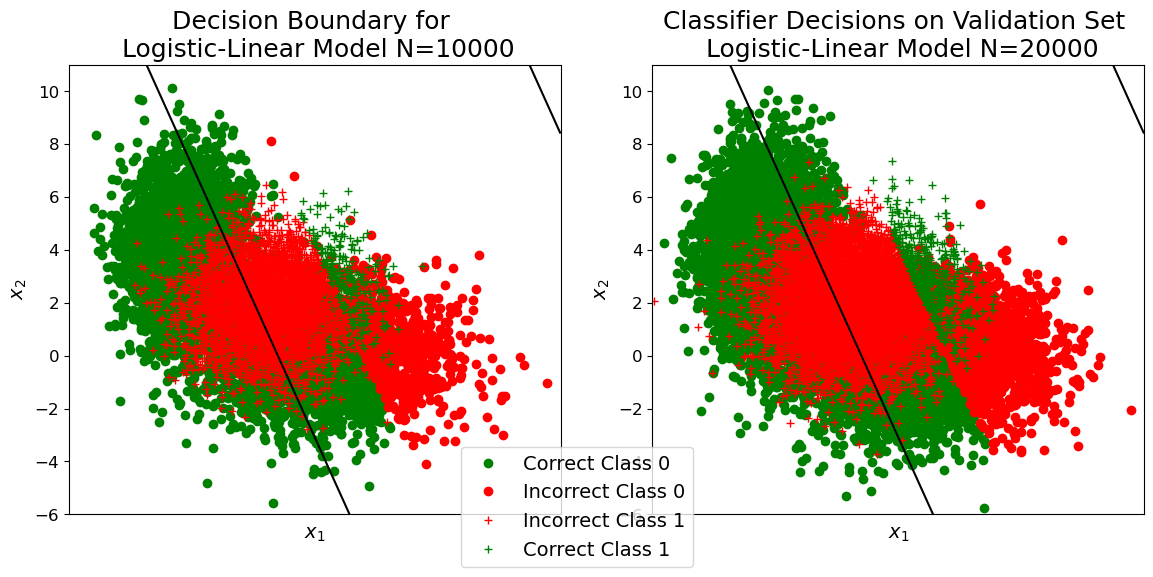

In [118]:
# Figure for D10K training decision boundary and D20K Classifier Decisions
fig_linear, (ax1, ax2) = plt.subplots(1,2, figsize = (12,6));
# D1000 training dataset
w_mle = estimateLogisticMLE(phi.fit_transform(D10K), D10K_labels)
print("Logistic-Linear N={}; MLE for w: {}".format(10000, w_mle))
prob_error = estimateLogisticResults(ax1, D10K, w_mle, D10K_labels, N_labels_train[2], phi)
print("Training set error for the N={} classifier is {:.3f}".format(10000, prob_error))
ax1.set_title("Decision Boundary for \n Logistic-Linear Model N={}".format(10000))
ax1.set_xticks([])
prob_error = estimateLogisticResults(ax2, D20K, w_mle, D20K_labels, Nl_valid, phi)
ax2.set_title("Classifier Decisions on Validation Set \n Logistic-Linear Model N={}".format(D_validate))
print("Validation set error for the N={} classifier is {:.3f}\n\n".format(10000, prob_error))
ax2.set_xticks([])
# Again use the most sampled subset (validation) to define x-y limits
plt.setp((ax1, ax2), xlim=x1_valid_lim, ylim=x2_valid_lim)
# Adjust subplot positions
plt.subplots_adjust(hspace=0.3)
# Super plot the legends
handles, labels = ax2.get_legend_handles_labels()
fig_linear.legend(handles, labels, loc='lower center')
plt.tight_layout()
plt.show()

### Part 3b

Logistic-Quadratic N = 100; MLE for w: [-1.4173726   1.31440138  0.80943457 -0.26831715  0.1106072  -0.20557331]
Training set error for the N = 100 classifier is 0.200
Validation set error for the N = 100 classifier is 0.190




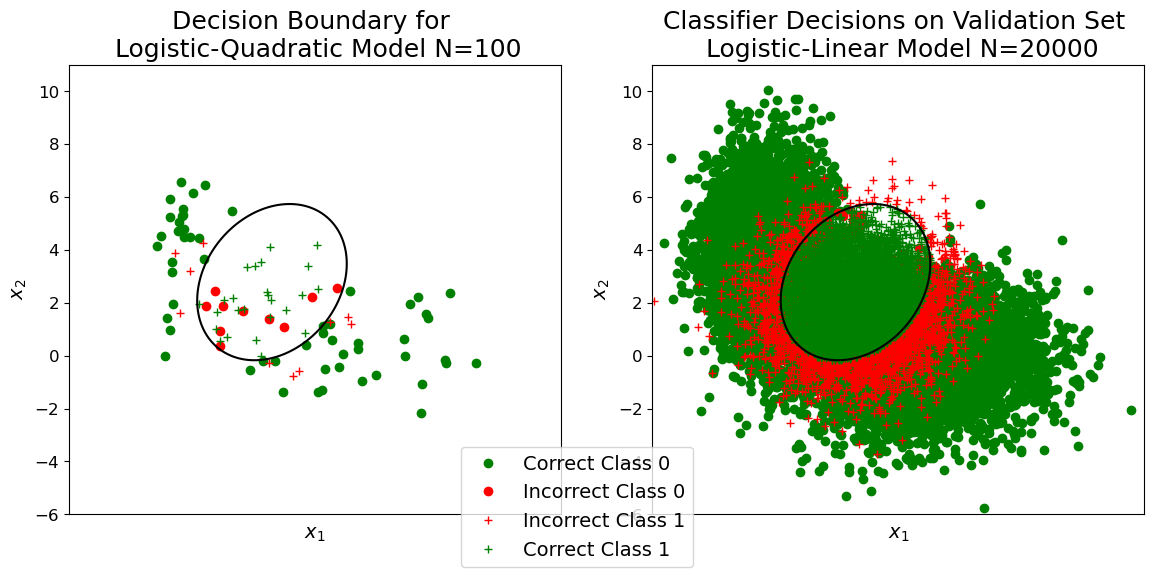

In [120]:
# Define phi transformation to only include a bias column
phi = PolynomialFeatures(degree=2)
# Figure for D100 training decision boundary and D20K Classifier Decisions
fig_quad, (ax1, ax2) = plt.subplots(1,2, figsize = (12,6));
# D100 training dataset
w_mle = estimateLogisticMLE(phi.fit_transform(D100), D100_labels)
print("Logistic-Quadratic N = {}; MLE for w: {}".format(100, w_mle))
prob_error = estimateLogisticResults(ax1, D100, w_mle, D100_labels, N_labels_train[0], phi)
print("Training set error for the N = {} classifier is {:.3f}".format(100, prob_error))
ax1.set_title("Decision Boundary for \n Logistic-Quadratic Model N={}".format(100))
ax1.set_xticks([])
prob_error = estimateLogisticResults(ax2, D20K, w_mle, D20K_labels, Nl_valid, phi)
ax2.set_title("Classifier Decisions on Validation Set \n Logistic-Quadratic Model N={}".format(D_validate))
print("Validation set error for the N = {} classifier is {:.3f}\n\n".format(100, prob_error))
ax2.set_xticks([])
# Again use the most sampled subset (validation) to define x-y limits
plt.setp((ax1, ax2), xlim=x1_valid_lim, ylim=x2_valid_lim)
# Adjust subplot positions
plt.subplots_adjust(hspace=0.3)
# Super plot the legends
handles, labels = ax2.get_legend_handles_labels()
fig_quad.legend(handles, labels, loc='lower center')
plt.tight_layout()
plt.show()

Second-order optimization of the NLL loss for a logistic-quadratic model applied to different training subsets

Logistic-Quadratic N=1000; MLE for w: [-0.3097881   0.99141678 -0.15686548 -0.23798112  0.3282232  -0.15269824]
Training set error for the N=1000 classifier is 0.196
Validation set error for the N=1000 classifier is 0.176




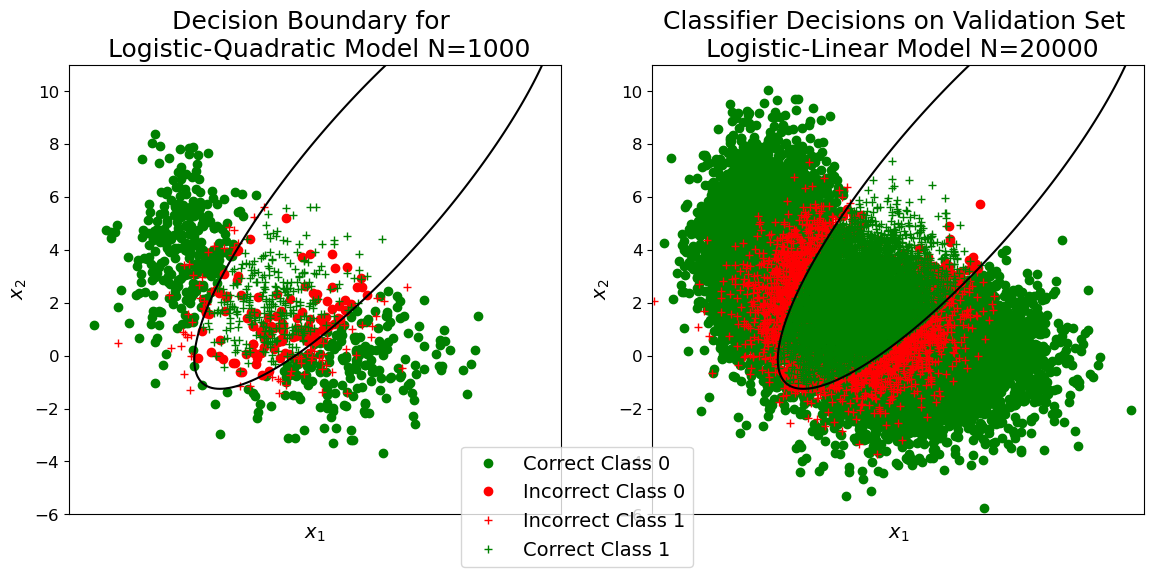

In [102]:
# Figure for D1K training decision boundary and D20K Classifier Decisions
fig_quad, (ax1, ax2) = plt.subplots(1,2, figsize = (12,6));
# D1K training dataset
w_mle = estimateLogisticMLE(phi.fit_transform(D1K), D1K_labels)
print("Logistic-Quadratic N={}; MLE for w: {}".format(1000, w_mle))
prob_error = estimateLogisticResults(ax1, D1K, w_mle, D1K_labels, N_labels_train[1], phi)
print("Training set error for the N={} classifier is {:.3f}".format(1000, prob_error))
ax1.set_title("Decision Boundary for \n Logistic-Quadratic Model N={}".format(1000))
ax1.set_xticks([])
prob_error = estimateLogisticResults(ax2, D20K, w_mle, D20K_labels, Nl_valid, phi)
ax2.set_title("Classifier Decisions on Validation Set \n Logistic-Quadratic Model N={}".format(D_validate))
print("Validation set error for the N={} classifier is {:.3f}\n\n".format(1000, prob_error))
ax2.set_xticks([])
# Again use the most sampled subset (validation) to define x-y limits
plt.setp((ax1, ax2), xlim=x1_valid_lim, ylim=x2_valid_lim)
# Adjust subplot positions
plt.subplots_adjust(hspace=0.3)
# Super plot the legends
handles, labels = ax2.get_legend_handles_labels()
fig_quad.legend(handles, labels, loc='lower center')
plt.tight_layout()
plt.show()

In [1]:
# Figure for D100 training decision boundary and D20K Classifier Decisions
fig_quad, (ax1, ax2) = plt.subplots(1,2, figsize = (12,6));
# D100 training dataset
w_mle = estimateLogisticMLE(phi.fit_transform(D10K), D10K_labels)
print("Logistic-Quadratic N={}; MLE for w: {}".format(10000, w_mle))
prob_error = estimateLogisticResults(ax1, D10K, w_mle, D10K_labels, N_labels_train[2], phi)
print("Training set error for the N={} classifier is {:.3f}".format(10000, prob_error))
ax1.set_title("Decision Boundary for \n Logistic-Quadratic Model N={}".format(10000))
ax1.set_xticks([])
prob_error = estimateLogisticResults(ax2, D20K, w_mle, D20K_labels, Nl_valid, phi)
ax2.set_title("Classifier Decisions on Validation Set \n Logistic-Quadratic Model N={}".format(D_validate))
print("Validation set error for the N={} classifier is {:.3f}\n\n".format(10000, prob_error))
ax2.set_xticks([])
# Again use the most sampled subset (validation) to define x-y limits
plt.setp((ax1, ax2), xlim=x1_valid_lim, ylim=x2_valid_lim)
# Adjust subplot positions
plt.subplots_adjust(hspace=0.3)
# Super plot the legends
handles, labels = ax2.get_legend_handles_labels()
fig_quad.legend(handles, labels, loc='lower center')
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

fitted model: <pykalman.standard.KalmanFilter object at 0x000001BBE928D760>


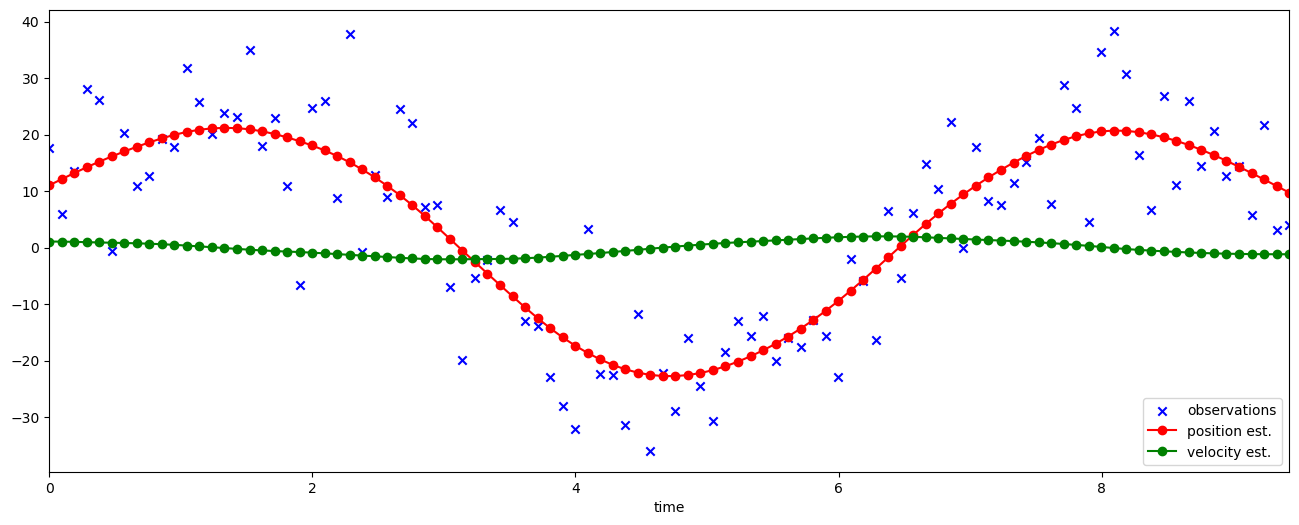

In [3]:
r'''
==================================
Kalman Filter tracking a sine wave
==================================
This example shows how to use the Kalman Filter for state estimation.
In this example, we generate a fake target trajectory using a sine wave.
Instead of observing those positions exactly, we observe the position plus some
random noise.  We then use a Kalman Filter to estimate the velocity of the
system as well.
The figure drawn illustrates the observations, and the position and velocity
estimates predicted by the Kalman Smoother.
'''
import numpy as np
import pylab as pl

from pykalman import KalmanFilter

rnd = np.random.RandomState(0)

# generate a noisy sine wave to act as our fake observations
n_timesteps = 100
x = np.linspace(0, 3 * np.pi, n_timesteps)
observations = 20 * (np.sin(x) + 0.5 * rnd.randn(n_timesteps))

# create a Kalman Filter by hinting at the size of the state and observation
# space.  If you already have good guesses for the initial parameters, put them
# in here.  The Kalman Filter will try to learn the values of all variables.
kf = KalmanFilter(transition_matrices=np.array([[1, 1], [0, 1]]),
                  transition_covariance=0.01 * np.eye(2))

# You can use the Kalman Filter immediately without fitting, but its estimates
# may not be as good as if you fit first.
states_pred = kf.em(observations).smooth(observations)[0]
print('fitted model: {0}'.format(kf))

# Plot lines for the observations without noise, the estimated position of the
# target before fitting, and the estimated position after fitting.
pl.figure(figsize=(16, 6))
obs_scatter = pl.scatter(x, observations, marker='x', color='b',
                         label='observations')
position_line = pl.plot(x, states_pred[:, 0],
                        linestyle='-', marker='o', color='r',
                        label='position est.')
velocity_line = pl.plot(x, states_pred[:, 1],
                        linestyle='-', marker='o', color='g',
                        label='velocity est.')
pl.legend(loc='lower right')
pl.xlim(xmin=0, xmax=x.max())
pl.xlabel('time')
pl.show()